In [1]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf

In [2]:
START = "2014-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Define a function to load the dataset

def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

In [3]:
data = load_data('MRF.NS')
df=data
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-01,19399.0,19499.900391,19216.000000,19276.949219,18953.873047,6371
1,2014-01-02,19366.0,19444.000000,18956.300781,19019.849609,18701.093750,10813
2,2014-01-03,19001.0,19249.000000,18905.099609,19162.650391,18841.500000,11415
3,2014-01-06,19174.0,19439.949219,19046.099609,19287.949219,18964.695312,13030
4,2014-01-07,19349.0,19450.000000,19056.050781,19120.349609,18799.906250,7225


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2647,2024-09-27,138700.0,142383.906250,138377.000000,140973.90625,140973.90625,12240
2648,2024-09-30,141000.0,141884.843750,138200.046875,138513.65625,138513.65625,6269
2649,2024-10-01,139600.0,140447.093750,138950.203125,140262.90625,140262.90625,3931
2650,2024-10-03,138000.0,139894.500000,135924.406250,136104.34375,136104.34375,7483
2651,2024-10-04,136600.0,136782.796875,133000.000000,133408.75000,133408.75000,10223


In [5]:
close_price = df['Close']

In [6]:
close_price_reverse = close_price.iloc[::-1]

close_price.reset_index(drop=True, inplace=True)

In [7]:
close_price_reverse

2651    133408.750000
2650    136104.343750
2649    140262.906250
2648    138513.656250
2647    140973.906250
            ...      
4        19120.349609
3        19287.949219
2        19162.650391
1        19019.849609
0        19276.949219
Name: Close, Length: 2652, dtype: float64

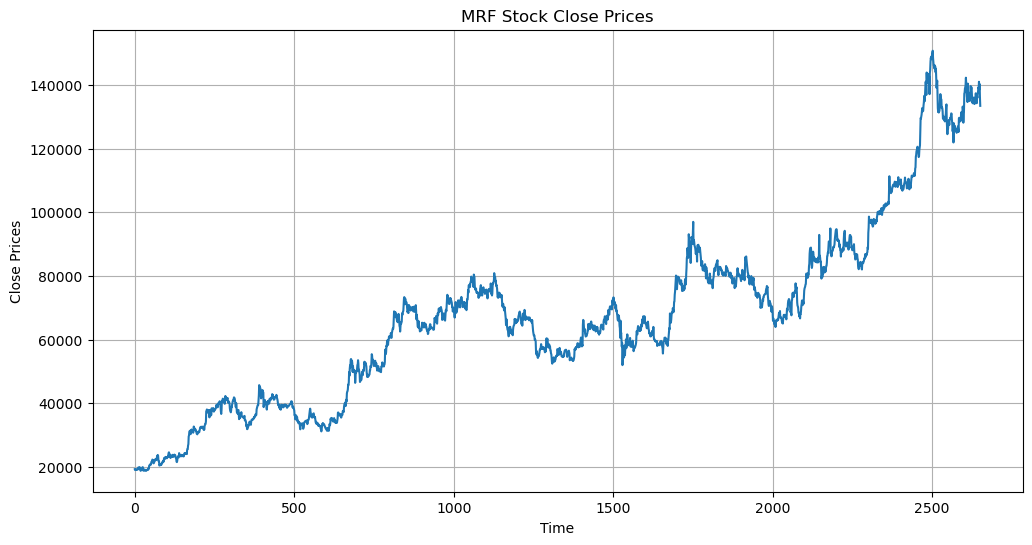

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(close_price)
plt.xlabel('Time')
plt.ylabel('Close Prices')
plt.title('MRF Stock Close Prices')
plt.grid(True)
plt.show()

In [9]:
#Data Preprocessing
data = close_price.values.reshape(-1,1)
data_normalized = data / np.max(data)

In [10]:
train_size = int(len(data_normalized) * 0.8)
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam

# Function to create LSTM model
def create_lstm_model(units, activation, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(1, 1)))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [12]:
# Define hyperparameters for tuning
lstm_units = [50, 100, 200]
lstm_activations = ['relu', 'tanh']
learning_rates = [0.001, 0.01, 0.1]
epochs = 100
batch_size = 32

In [13]:
# Perform hyperparameter tuning for LSTM model
best_rmse = float('inf')
best_lstm_model = None

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
for units in lstm_units:
    for activation in lstm_activations:
        for learning_rate in learning_rates:
            # Create and train LSTM model
            model = create_lstm_model(units=units, activation=activation, learning_rate=learning_rate)
            model.fit(train_data[:-1].reshape(-1, 1, 1), train_data[1:], epochs=epochs, batch_size=batch_size, verbose=0)

            # Predict on test data
            test_predictions = model.predict(test_data[:-1].reshape(-1, 1, 1)).flatten()

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(test_data[1:], test_predictions))

            # Check if current model has lower RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_lstm_model = model

2024-10-07 15:08:02.850652: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-10-07 15:08:02.850715: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-07 15:08:02.850761: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-07 15:08:02.852013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-07 15:08:02.852680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-10-07 15:08:05.043832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:09:13.537973: I te

17/17 [==============================] - 2s 39ms/step


2024-10-07 15:09:15.456345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 6ms/step


2024-10-07 15:10:12.601115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:10:13.219459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 6ms/step


2024-10-07 15:11:10.844511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:11:12.257269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:11:12.395647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:11:12.870141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/17 [>.............................] - ETA: 3s

2024-10-07 15:11:48.262936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:11:48.300849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 10ms/step


2024-10-07 15:11:49.154108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:11:49.264890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:11:49.348074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 3ms/step


2024-10-07 15:12:22.108601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:12:22.147708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:12:22.913477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:12:23.031568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:12:23.109596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 3ms/step


2024-10-07 15:12:54.629635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:12:54.666801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:12:55.418215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:13:54.861761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 37ms/step


2024-10-07 15:13:56.399698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 6ms/step


2024-10-07 15:14:52.140897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:14:53.227239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 6ms/step


2024-10-07 15:15:53.143713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:15:53.986288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:15:54.106129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:15:54.283449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/17 [>.............................] - ETA: 4s

2024-10-07 15:16:27.162293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:16:27.204762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 11ms/step


2024-10-07 15:16:28.185488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:16:28.295050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:16:28.378210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 3ms/step


2024-10-07 15:16:59.435651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:16:59.473598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:17:00.273024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:17:00.388313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:17:00.470093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 3ms/step


2024-10-07 15:17:29.847204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:17:29.883750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:17:30.526775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 9/17 [==============>...............] - ETA: 0s

2024-10-07 15:18:31.415416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 7ms/step


2024-10-07 15:18:32.731385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 5ms/step


2024-10-07 15:19:31.998750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:19:32.612551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 6ms/step


2024-10-07 15:20:31.979156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:20:32.859587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:20:32.986807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:20:33.400213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 3ms/step


2024-10-07 15:21:06.608656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:21:06.649580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:21:07.468737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:21:07.586620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:21:07.676991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/17 [=======================>......] - ETA: 0s

2024-10-07 15:21:39.099925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:21:39.138425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 6ms/step


2024-10-07 15:21:39.969183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:21:40.090644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:21:40.177347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 3ms/step


2024-10-07 15:22:10.856099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-07 15:22:10.892880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [16]:
# Predict on the entire dataset using the best LSTM model
all_lstm_predictions = best_lstm_model.predict(data_normalized[:-1].reshape(-1, 1, 1)).flatten()

# Inverse normalize the LSTM predictions
all_lstm_predictions = all_lstm_predictions * np.max(data)

# Calculate the scaling factor based on the maximum value of the original data
scaling_factor = np.max(close_price)

83/83 [==============================] - 0s 4ms/step


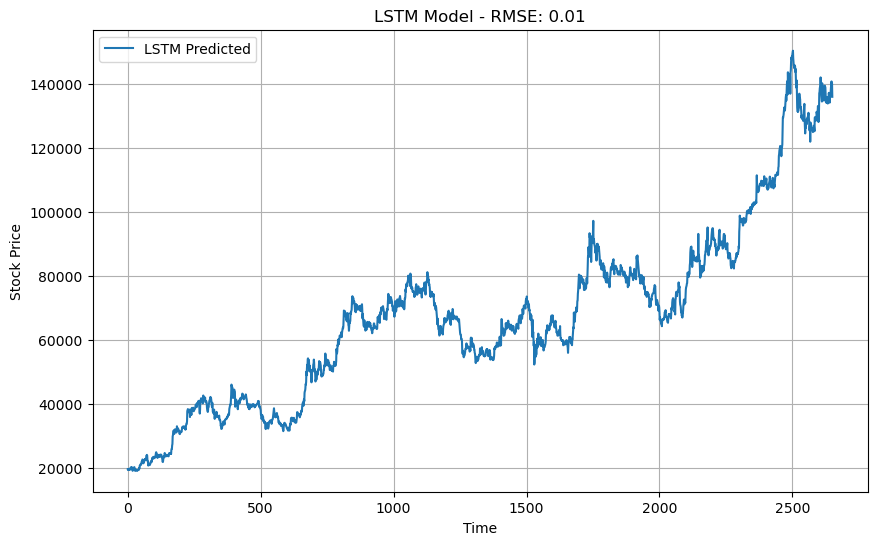

In [17]:
# Plotting LSTM predictions
plt.figure(figsize=(10, 6))
plt.plot(all_lstm_predictions, label='LSTM Predicted')
plt.title(f"LSTM Model - RMSE: {best_rmse:.2f}")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

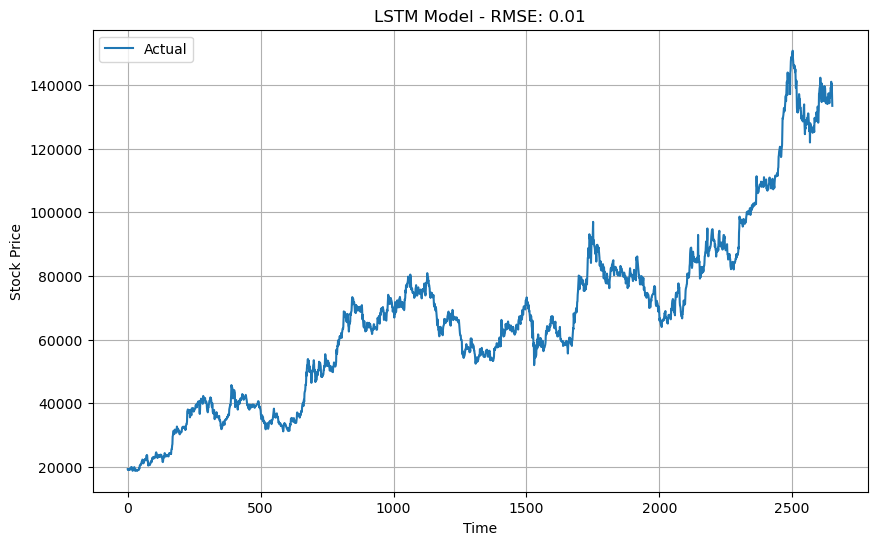

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(close_price, label='Actual')
plt.title(f"LSTM Model - RMSE: {best_rmse:.2f}")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def predict_future_lstm(model, data, num_predictions, scaling_factor):
    predictions = []

    # Get the last data point from the input data
    last_data_point = data[-1]

    for _ in range(num_predictions):
        # Predict the next time step
        prediction = model.predict(last_data_point.reshape(1, 1, 1))
        predictions.append(prediction[0, 0])

        # Update last_data_point to include the predicted value for the next iteration
        last_data_point = np.append(last_data_point[1:], prediction)

    # Inverse normalize the predictions
    predictions = np.array(predictions) * scaling_factor

    return predictions

1/1 [==============================] - 0s 12ms/step


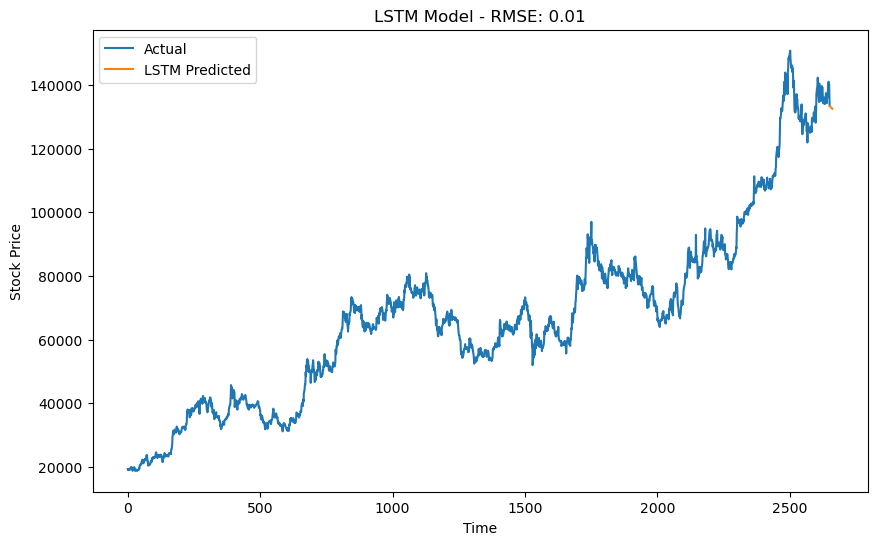

In [24]:
num_predictions = 10
lstm_predictions = predict_future_lstm(best_lstm_model, data_normalized, num_predictions, scaling_factor)

# Plot the LSTM predictions for the next 10 days
plt.figure(figsize=(10, 6))
plt.plot(close_price, label='Actual')
plt.plot(np.arange(len(close_price), len(close_price) + num_predictions), lstm_predictions, label='LSTM Predicted')
plt.title(f"LSTM Model - RMSE: {best_rmse:.2f}")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [25]:
print("Predicted stock prices for the next 10 days:")
for i, prediction in enumerate(lstm_predictions, start=1):
    print(f"Day {i}: {prediction:.2f}")

Predicted stock prices for the next 10 days:
Day 1: 133311.56
Day 2: 133215.58
Day 3: 133120.75
Day 4: 133027.08
Day 5: 132934.55
Day 6: 132843.14
Day 7: 132752.86
Day 8: 132663.67
Day 9: 132575.55
Day 10: 132488.50


In [26]:
model.save('keras_model.keras')